In [1]:
import plons
import os
import math                     as math
import numpy                    as np
import matplotlib.pyplot        as plt
# import necessary plons scripts
import plons.SmoothingKernelScript        as sk
import plons.ConversionFactors_cgs        as cgs
import plons.GeometricalFunctions         as gf

'''
All used definitions:
'''

In [2]:
#Definitions for coordinate transformation

'''
calculate new radii after change coordinate center to position second sink particle, and rotation such that AGB is on -x axis
'''

def calc_new_position(x,y,dumpData):
    # translation with rcomp:
    tr_x = x - dumpData['posComp'][0]
    tr_y = y - dumpData['posComp'][1]
    
    # rotation 
    theta   = - (gf.calcPhi([dumpData['posAGB'][0]],[dumpData['posAGB'][1]], 0)-np.pi)
    # print('theta rotation is ',theta)
    final_x = tr_x * np.cos(theta) - tr_y * np.sin(theta)
    final_y = tr_x * np.sin(theta) + tr_y * np.cos(theta)
        
    final_rxy = gf.calc_r_2D(final_x,final_y)
     
    return final_x,final_y,final_rxy


'''
Calculate velocities with velocity of companion as (0,0,0)
'''
def calc_new_velocities(vx,vy,vz,dumpData):
    new_vx = vx - dumpData['velComp'][0]/cgs.kms
    new_vy = vy - dumpData['velComp'][1]/cgs.kms
    new_vz = vz - dumpData['velComp'][2]/cgs.kms
    return (new_vx,new_vy,new_vz)

In [3]:
# Definitions for calculations scale height, mass, radius

'''
Adapted function from SmoothingKernelScript, to get pixCoord needed for function getSmoothingKernelledPix
'''
def getPixCoord(bound,n_grid,rx,ry):
    pix = np.linspace(-np.abs(bound),np.abs(bound), n_grid)
    pixCoord = []
    for i in range(len(pix)):
        # for j in range(len(pix_y)):
        pixCoord.append([rx, ry, pix[i]])
    pixCoord = np.array(pixCoord)
    return pixCoord


'''
Calculates the density on a vertical line trhough the orbital plane coordinates (r,theta) with companion sink particle as origin, using the smoothing kernel
theta = 0  --> z-line through point on x-axis (through sink particle companion)
theta = 90 --> z-line through point on y-axis (through sink particle companion)
'''

def getRhoOnZline(dumpData,r,theta,bound,n_grid):
    #getSmoothingKernelledPix uses old position! so adapt rx and ry here (translation, and rotation by extra theta)
    theta_new = theta + (gf.calcPhi([dumpData['posAGB'][0]],[dumpData['posAGB'][1]], 0)[0]-np.pi)
    rx = dumpData['posComp'][0] + r * np.cos(theta_new) 
    ry = dumpData['posComp'][1] + r * np.sin(theta_new)

    pixCoord = getPixCoord(bound,n_grid,rx,ry)
    
    results_line_H = sk.getSmoothingKernelledPix(20, dumpData, ['rho'], pixCoord)
    return pixCoord[:, 2], results_line_H['rho']


'''
Calculate scale height at orbital plane location (r,theta)
Use mean scale height in -h and +h direction

input: 
rho - h profile calculated with smoothing kernel

output:
SHmean      scale height estimate 
rhoSH       density value at this scale height (rhoMax/e)
'''


def findScaleHeight(zH,rho_zH,xH):
    # max of density on line
    rhoMax  = np.max(rho_zH)
    # Calculate rho value for z = 1* or 2* density scale height
    if xH == '1H':
        rhoSH = rhoMax/(np.sqrt(np.e))
    elif xH == '2H':
        rhoSH = rhoMax/(np.e**2)

    # find index where scale height h=0
    h0_ind  = np.argmin(np.array(np.abs(zH)))
    # Make array with rho values for positive h
    rho_zHp = rho_zH[h0_ind:]
    # Make array with rho values for negative h (going from 0 -> -...)
    rho_zHn = np.flip(rho_zH[:h0_ind])
    
    # if the scale height density is in the arrays of rho values for positive and negative h
    if np.min(rho_zHp) < rhoSH and np.min(rho_zHn)<rhoSH:
        # find indices of scale height for positive and negative h
        SHp_ind = np.argwhere(np.array(rho_zHp)<rhoSH)[0]
        SHn_ind = np.argwhere(np.array(rho_zHn)<rhoSH)[0]
        # make arrays with positive and negative h values (going from 0 -> ...)
        zHp     = zH[h0_ind:]
        zHn     = np.flip(zH[:h0_ind])
        # Find positive and negative h values for scale height
        SHp     = zHp[SHp_ind][0]
        SHn     = zHn[SHn_ind][0]
        # estimate scale height as mean of positive and negative scale height h
        SHmean  = (np.abs(SHp)+np.abs(SHn))/2
        
    # if the scale height density is not in the array of rho values, set to 0. This will not be added to the array that is used to calculate the median/mean
    else:
        print('!! At this theta direction, you are no longer in the disk or you set your maxH too small!!')
        SHmean  = 0
    return SHmean,rhoSH



'''
calculate an array of scale heights for one r for various theta, and make rho-h plot 

input
r                    radius for which scale height estimates are calculated [cm]
thetaArray           array with theta values (direction in orbital plane) over which the scale height is calculated
dumpData             input data, used for density and position
maxH                 maximum possible scale height estimate (calculations only done for h<maxH)
n_grid               #pixels used for calculations smoothing kernel
run                  modelName, used to save in correct locations

output
SH_array_one_r       array with scale height estimates for input r
plot with density - z height for each theta (fixed r)
'''

def getSH_andPlot_one_r(r,thetaArray,dumpData,maxH,n_grid,run,xH):
    #parameter used for plotcolors
    ci = 0
    SH_array_one_r = np.array([]) 
    #comment if you dont want plots
    # plt.figure()
    
    #calculate scale height estimate for each theta in the array
    for theta in thetaArray:
        # Convert theta to degrees for text output and plotlabels
        legendTh  = str(np.round(theta*180/np.pi,2))
        # print('theta',legendTh)
        
        # use smoothing kernel to calculate rhovalues on a line in the z-direction at location (r,theta) in orbital plane
        zH,rho_zH = getRhoOnZline(dumpData,r,theta,maxH,n_grid)
        
        # use rho profile to estimate the scale height at this location (mean of the + and - z scale height)
        SHmean, rhoSH = findScaleHeight(zH,rho_zH,xH)
        
        # if for this theta a scale height is calculated
        if SHmean >0:
            # add to array (later mean/median of this array will be taken as scale height estimate)
            SH_array_one_r   = np.append(SH_array_one_r, SHmean)
            #Comment if you dont want you dont want plots
            # plt.semilogy(zH/cgs.au,rho_zH,'-',label=r'$\theta$='+legendTh, c= 'C'+str(ci))  #semilogy
            # plt.axhline(y=rhoSH,  color='C'+str(ci), linestyle='--',linewidth = 0.7)
            # plt.axhline(y=-rhoSH,  color='C'+str(ci), linestyle='--',linewidth = 0.7)
            # plt.axvline(x=SHmean/cgs.au, color='C'+str(ci), linestyle = '--',linewidth = 0.7)
            # plt.axvline(x=-SHmean/cgs.au, color='C'+str(ci), linestyle = '--',linewidth = 0.7)
        ci = ci +1
        
    # change r to au for labels/text
    r_au =np.round(r/cgs.au,2)        
    #Comment if you dont want plots
    # plt.ylim(1e-17,2e-11)
    # plt.xlim(-maxH/cgs.au,maxH/cgs.au)
    # plt.ylabel('log rho')
    # plt.xlabel('h [au]')
    # plt.legend()
    # plt.title('r = '+str(r_au)+' au' )
    # plt.savefig(run+'plotsAnalysis/H_Rho_forDifferentTheta+'_wind_00'+str(dump)+'_'+xH+'.png')
    # plt.close()
    return SH_array_one_r

'''
Calculate for each r starting from lowerR, and increasing with r_step the scale height and disk mass
stops when relative increase in mass/rstep > crit

input
lowerR, r_step       startValue r and step with which it is increased for all calculations
thetaArray           array with theta values (direction in orbital plane) over which the mean/median scale height is calculated
dumpData             input data, used for density and position
maxH                 maximum possible scale height estimate (calculations only done for h<maxH)
n_grid               #pixels used for calculations smoothing kernel
run                  modelName, used to save in correct locations
crit                 criterium deciding when increase in mass is no longer relevant, and we are outside the disk (usually 0.2 looks good)


returns:
r_array              array with r values, and maxr is estimate of radius (where crit is met)
totalMassDisk        array with estimate of the total mass of the disk for each r in r_array
rel_mass_added       array with for each r value the mass_added wrt previous r value / totalMassDisk at this r
SH_array             array with scale height estimate for each r value

'''

def get_SH_diskMass_radius(lowerR,r_step,thetaArray,dumpData,maxH,n_grid,run,crit,xH,phiQuadr = False):
    # Make array to store the SH estimate for each r (0 at r=0.01 au (racc))
    SH_array = np.array([0.01]) 
    # Make array to store the total mass of the disk at each r (0 at r=0)
    totalMassDisk  = np.array([0]) 
    # Make array to store the relative added mass of the disk at each r (1 at r=0)
    rel_mass_added = np.array([1])

    # For each radius ri in the given array, but starting from r=racc
    r_array = np.append([0.01*cgs.au],lowerR*cgs.au)
    i=0
    # Calculate for each r the scale height and disk mass, until the relative mass added exceeds 0.01
    while rel_mass_added[-1]/r_step>crit:        
        r = r_array[i+1]
        print('---------')
        print('r',np.round(r/cgs.au,3),' au')
        
        # Calculate for every theta in thetaArray the scale height for this r value 
        SH_array_one_r = getSH_andPlot_one_r(r,thetaArray,dumpData,maxH,n_grid,run,xH)
        
        # Calculate the median of the scale heights for different theta values
        medianSH_one_r = np.median(SH_array_one_r)
        print('scale height is ',medianSH_one_r/cgs.au)
        # add the median scale height to an array containing the scale height estimate for each r value
        SH_array = np.append(SH_array,medianSH_one_r)   

        if phiQuadr == True:
            maxTheta = thetaArray[-1]
            minTheta = thetaArray[0]
            # print(maxTheta-minTheta)
            if np.abs(maxTheta-minTheta)<np.pi: #normal theta array:
                filter = (r_array[i] < dumpData['new_r']) & (dumpData['new_r'] < r_array[i+1]) & (np.abs(dumpData['position'][:,2]) < SH_array[i+1]) & (dumpData['new_Phi']<maxTheta) & (dumpData['new_Phi']>minTheta)
                mass_added = np.sum(dumpData['mass'][filter])
            else: #theta array around 0:
                # add everything with theta between 0 and thetamax
                filter = (r_array[i] < dumpData['new_r']) & (dumpData['new_r'] < r_array[i+1]) & (np.abs(dumpData['position'][:,2]) < SH_array[i+1]) & (dumpData['new_Phi']<maxTheta)
                mass_added_1 = np.sum(dumpData['mass'][filter])
                # add everything with theta between thetamin and 2pi
                filter = (r_array[i] < dumpData['new_r']) & (dumpData['new_r'] < r_array[i+1]) & (np.abs(dumpData['position'][:,2]) < SH_array[i+1]) & (dumpData['new_Phi']>minTheta)
                mass_added_2 = np.sum(dumpData['mass'][filter])
                mass_added = mass_added_1+mass_added_2
        else:
            filter = (r_array[i] < dumpData['new_r']) & (dumpData['new_r'] < r_array[i+1]) & (np.abs(dumpData['position'][:,2]) < SH_array[i+1])
            mass_added = np.sum(dumpData['mass'][filter])


        mass_added = np.sum(dumpData['mass'][filter])
        print('mass added [Msun]: ',mass_added/cgs.Msun)
        # Update totalMassDisk
        totalMassDisk  = np.append(totalMassDisk,(totalMassDisk[i] + mass_added))
        if totalMassDisk[-1]>0:
            # calculate how much mass is added relatively in this step
            rel_mass_added = np.append(rel_mass_added,mass_added/totalMassDisk[-1])
        else: 
            rel_mass_added = np.append(rel_mass_added,r_step)
            
        print('relMass_added/rstep (rico) = ',np.round(rel_mass_added[-1]/r_step,3))
        
        i = i+1    
        # update r_array with r(i+1)
        r_array = np.append(r_array,[(lowerR+r_step*i)*cgs.au]) 
        
    print('-------------------------------------------------------------')
    print('estimate of r of the accretion disk is ',r_array[i]/cgs.au,' au')
    return (r_array,totalMassDisk,rel_mass_added,SH_array)


In [4]:
# Definition to plot rho ifo h for each theta, with varying radius
'''
Make rho-h plots for each theta with varying r
Calculates scale height for each theta for various r to make one rho-h plot for each theta value

input
rArray               array with r-values used for calculations
thetaArray           array with theta values (direction in orbital plane) for which a plot will be made for the full array of r-values
dumpData             input data, used for density and position
maxH                 maximum possible scale height estimate (calculations only done for h<maxH)
n_grid               #pixels used for calculations smoothing kernel
run                  modelName, used to save in correct locations

'''
def plotRhoVert_fixedTheta(rArray,thetaArray,dumpData,maxH,n_grid,run,xH):
    for theta in thetaArray:
        legendTh  = theta*180/np.pi
        print('---------')
        print('theta',legendTh)
        ci = 0
        plt.figure()
        for r_au in rArray:
            # r in au used for plotLabels
            r_au = np.round(r_au,3)
            r      = r_au *cgs.au
            # Use smoothing kernel to calculate density on a z-line (at position (r,theta) in orbital plane)
            zH,rho_zH = getRhoOnZline(dumpData,r,theta,maxH,n_grid)
            # calculate scale height at this position
            SHmean, rhoSH = findScaleHeight(zH,rho_zH,xH)
            # if scale height is calculated, add density profile, scale height, and density at scale height to plot
            if SHmean!= 0:
                plt.semilogy(zH/cgs.au,rho_zH,'-',label='r= '+str(r_au)+' au')
                plt.axhline(y=rhoSH,  color='C'+str(ci), linestyle='--',linewidth = 0.5)
                plt.axvline(x=SHmean/cgs.au, color='C'+str(ci), linestyle = '--',linewidth = 0.5)
                plt.axvline(x=-SHmean/cgs.au, color='C'+str(ci), linestyle = '--',linewidth = 0.5)
            ci = ci +1          
        plt.ylim(1e-17,2e-11)
        plt.xlim(-maxH/cgs.au,maxH/cgs.au)
        plt.ylabel('log rho')
        plt.xlabel('h [au]')
        plt.legend(loc = 'upper right')
        plt.title('theta = '+str(legendTh))
        plt.savefig(run+'plotsAnalysis/H_rho_forTheta'+str(legendTh)+'_'+str(ci)+'r.png')
        plt.close()

In [5]:
'''
Perform tests after calculation new position to ensure that positions and theta angles are correct:

input
dumpData             input data, used for density and position
run                  modelName, used to save in correct locations
dump                 dumpNumber, used to save under correct name
'''
def testPositionAndTheta(dumpData,run,dump):
    print('test if coordinate transformation is correct')
    new_x_AGB, new_y_AGB, new_r_AGB = calc_new_position([dumpData['posAGB'][0]],[dumpData['posAGB'][1]],dumpData)
    if new_x_AGB>0 or np.abs(new_y_AGB/cgs.au)>0.1:
        print('!INCORRECT COORDINATE TRANSFORMATION!')
        print(new_x_AGB/cgs.au,new_y_AGB/cgs.au)
    else:
        print('AGB is on negative x-axis, companion is at (0,0)')
    
    ## Make plots to test if theta angle makes sense
    plt.figure()
    plt.plot(dumpData['new_x'][::100]/cgs.au,dumpData['new_Phi'][::100],'*')
    plt.axvline(x=new_x_AGB/cgs.au)
    plt.xlabel(r'x[au]')
    plt.ylabel(r'$\theta$')
    plt.axhline(y = [np.pi/4])
    plt.axhline(y = [3*np.pi/4])
    plt.axhline(y = [5*np.pi/4])
    plt.axhline(y = [7*np.pi/4])
    plt.savefig(run+'plotsAnalysis/theta_x_wind_00'+str(dump)+'.png')#_diffScaleHeightDef_e**2.png')
    plt.close()

    plt.figure()
    plt.plot(dumpData['new_y'][::100]/cgs.au,dumpData['new_Phi'][::100],'*')
    plt.axvline(0)
    plt.xlabel(r'y[au]')
    plt.ylabel(r'$\theta$')
    plt.axhline(y = [np.pi/4])
    plt.axhline(y = [3*np.pi/4])
    plt.axhline(y = [5*np.pi/4])
    plt.axhline(y = [7*np.pi/4])
    plt.savefig(run+'plotsAnalysis/theta_y_wind_00'+str(dump)+'.png')#_diffScaleHeightDef_e**2.png')
    plt.close()      

In [6]:
'''
Definitions to make plots of data
'''
### For full theta region
'''
Plot of relative mass added / rstep
'''
def plot_relAddedMass(r_array,rel_mass_added,r_step,crit,xH):
    plt.figure()
    plt.plot(r_array[1:-1]/cgs.au,rel_mass_added[1:]/r_step) 
    plt.axhline(y=crit,color = 'k',linestyle= '--',linewidth = 0.7)
    plt.axvline(x=r_array[-2]/cgs.au, linestyle= '--',linewidth = 0.7)
    plt.xlabel('r [au]')
    plt.ylabel('relative added mass / rstep')
    plt.savefig(run+'plotsAnalysis/RelMvsR_wind_00'+str(dump)+'_'+xH+'.png')

'''
Plot of total disk mass added ifo r
'''
def plot_totalDiskMass(r_array,totalMassDisk,xH):
    plt.figure()
    plt.plot(r_array[1:-1]/cgs.au,totalMassDisk[1:]/cgs.Msun,label='cumulative total disk mass')
    plt.legend()
    plt.xlabel('r [au]')
    plt.ylabel('disk mass [Msun]')
    plt.savefig(run+'plotsAnalysis/MvsR_rstep_wind_00'+str(dump)+'_'+xH+'.png')

'''
Plot of scale heights ifo r
'''
def plot_scaleHeights(r_array,SH_array,xH):
    plt.figure()
    plt.plot(r_array[1:-1]/cgs.au,SH_array[1:]/cgs.au,label='scale height')
    plt.legend()
    plt.xlabel('r [au]')
    plt.ylabel('scale height [au]')
    plt.savefig(run+'plotsAnalysis/SHvsR_rstep_wind_00'+str(dump)+'_'+xH+'.png')

    
### For 4 theta regions
    
'''
Plot of relative mass added / rstep for different theta regimes
'''
def plot_relAddedMass_4theta(r_array1,r_array2,r_array3,r_array4,rel_mass_added1,rel_mass_added2,rel_mass_added3,rel_mass_added4,r_step1,r_step3,dump,crit,xH):
    plt.figure()
    plt.plot(r_array1[1:-1]/cgs.au,rel_mass_added1[1:]/r_step1,label='th1: -pi/4 - +pi/4', c='C1')
    plt.plot(r_array2[1:-1]/cgs.au,rel_mass_added2[1:]/r_step1,label='th2: pi/4 - 3pi/4', c='C2')
    plt.plot(r_array3[1:-1]/cgs.au,rel_mass_added3[1:]/r_step3,label='th3: 3pi/4 - 5pi/4', c='C3')
    plt.plot(r_array4[1:-1]/cgs.au,rel_mass_added4[1:]/r_step1,label='th4: 5pi/4 - 7pi/4', c='C4')

    plt.axhline(y=crit,color = 'k',linestyle= '--',linewidth = 0.7)
    plt.axvline(x=r_array1[-2]/cgs.au, c='C1', linestyle= '--',linewidth = 0.7)
    plt.axvline(x=r_array2[-2]/cgs.au, c='C2', linestyle= '--',linewidth = 0.7)
    plt.axvline(x=r_array3[-2]/cgs.au, c='C3', linestyle= '--',linewidth = 0.7)
    plt.axvline(x=r_array4[-2]/cgs.au, c='C4', linestyle= '--',linewidth = 0.7)

    plt.legend()
    plt.xlabel('r [au]')
    plt.ylabel('relative added mass / rstep')
    plt.savefig(run+'plotsAnalysis/Theta_RelMvsR_rstep_wind_00'+str(dump)+'_'+xH+'.png')
    
'''
Plot of total disk mass added ifo r for different theta regimes
'''
def plot_totalDiskMass_4theta(r_array1,r_array2,r_array3,r_array4,totalMassDisk1,totalMassDisk2,totalMassDisk3,totalMassDisk4,dump,xH):
    plt.figure()
    plt.plot(r_array1[1:-1]/cgs.au,totalMassDisk1[1:]/cgs.Msun,label='th1: -pi/4 - +pi/4', c='C1')
    plt.plot(r_array2[1:-1]/cgs.au,totalMassDisk2[1:]/cgs.Msun,label='th2: pi/4 - 3pi/4', c='C2')
    plt.plot(r_array3[1:-1]/cgs.au,totalMassDisk3[1:]/cgs.Msun,label='th3: 3pi/4 - 5pi/4', c='C3')
    plt.plot(r_array4[1:-1]/cgs.au,totalMassDisk4[1:]/cgs.Msun,label='th4: 5pi/4 - 7pi/4', c='C4')
    plt.legend()
    plt.xlabel('r [au]')
    plt.ylabel('disk mass [Msun]')
    plt.savefig(run+'plotsAnalysis/Theta_MvsR_rstep_wind_00'+str(dump)+'_'+xH+'.png')

'''
Plot of scale heights ifo r for different theta regimes
'''
def plot_scaleHeights_4theta(r_array1,r_array2,r_array3,r_array4,SH_array1,SH_array2,SH_array3,SH_array4,r_step1,dump,xH):

    plt.figure()
    plt.plot(r_array1[1:-1]/cgs.au,SH_array1[1:]/cgs.au,label='th1: -pi/4 - +pi/4', c='C1')
    plt.plot(r_array2[1:-1]/cgs.au,SH_array2[1:]/cgs.au,label='th2: pi/4 - 3pi/4', c='C2')
    plt.plot(r_array3[1:-1]/cgs.au,SH_array3[1:]/cgs.au,label='th3: 3pi/4 - 5pi/4', c='C3')
    plt.plot(r_array4[1:-1]/cgs.au,SH_array4[1:]/cgs.au,label='th4: 5pi/4 - 7pi/4', c='C4')

    plt.legend()
    plt.xlabel('r [au]')
    plt.ylabel('scale height [au]')
    plt.savefig(run+'plotsAnalysis/Theta_SHvsR_rstep_wind_00'+str(dump)+'_'+xH+'.png')

In [7]:
def writeFile(title,r_step,testLimit,r_array,rel_mass_added,totalMassDisk,SH_array):
    with open (title,'w') as f:
        # f.write('Model '+str(run)+'\n')
        f.write('Data analysis accretion disks')
        f.write('\n')
        f.write('\n')    
        f.write('for rstep '+ str(r_step)+ ' au (=racc) and limit of '+ str(testLimit)+':'+'\n')
        f.write('the estimated radius is:           '+ str(np.round(r_array[np.where(rel_mass_added/r_step<testLimit)][0]/cgs.au,3))+' au'+'\n')
        f.write('the estimated total mass is:       '+ str(np.round(totalMassDisk[np.where(rel_mass_added/r_step<testLimit)][0]/cgs.Msun,11))+' Msun'+'\n')
        f.write('the estimated max scale height is: '+ str(np.round(SH_array[np.where(rel_mass_added/r_step<testLimit)][0]/cgs.au,3))+' au'+'\n')
        f.write('\n')
        f.write('\n')
        f.write('for rstep 0.01 au (=racc):'+'\n')
        names = ['r [au]', 'SH [au]', 'Mtot [Msun]', 'Mrel/rstep []', 'Mrel []']
        f.write("{: <30} {: <30} {: <30}  {: <30} {: <30} ".format(*names))
        col_format = "{:<31}" * 5 + "\n"   # 5 left-justfied columns with 15 character width
        f.write('\n')
        for i in zip(np.round(r_array/cgs.au,2),np.round(SH_array/cgs.au,4),np.round(totalMassDisk/cgs.Msun,13),np.round(rel_mass_added/r_step,3),np.round(rel_mass_added,3)):
            f.write(col_format.format(*i))

In [8]:
'''
Calculate scale height and disk mass ifo radius, and estimate radius, using the median scale height of $numberOfThetas theta directions
Make plots
Save data in txt file

input
dumpData             input data, used for density and position
run                  modelName, used to save in correct locations
dump                 dumpNumber, used to save under correct name
'''

def fullThetaCalculations(dumpData,run,dump,xH):
    # Choose which and how many r and theta values you want to use to calculate scale heights and disk mass and for plot of rho vs h
    n_grid         = 10000
    # maxH           = 3 *cgs.au 
    maxH           = 1.5 *cgs.au    # for v20e00, v10e00

    numberOfThetas = 10
    thetaMin       = 0
    thetaMax       = 2*np.pi
    thetaArray     = np.linspace(thetaMin,(numberOfThetas-1)/numberOfThetas*thetaMax,numberOfThetas)

    # crit           = 0.2   --> appeared to be too small for some models to converge
    crit           = 0.3
    # crit           = 2     #TEST
    lowerR         = 0.02
    r_step         = 0.01

    # Calculate arrays with radii, disk mass, relative addes mass, and scale heights
    r_array,totalMassDisk,rel_mass_added,SH_array =  get_SH_diskMass_radius(lowerR,r_step,thetaArray,dumpData,maxH,n_grid,run,crit,xH,phiQuadr = False)
    
    '''
    Write data for full theta region in txt file infoAccrDisk_wind_00....txt
    '''
    testLimit = crit

    title = os.path.join(run,'plotsAnalysis/infoAccrDisk_wind_00'+str(dump)+'_'+xH+'.txt')
    with open (title,'w') as f:
        f.write('Model '+str(run)+'wind_00'+str(dump)+'\n')
        f.write('Data analysis accretion disks')
        f.write('\n')
        f.write('\n')    
        f.write('for rstep '+ str(r_step)+ ' au (=racc) and limit of '+ str(testLimit)+':'+'\n')
        f.write('the estimated radius is:           '+ str(np.round(r_array[np.where(rel_mass_added/r_step<testLimit)][0]/cgs.au,3))+' au'+'\n')
        f.write('the estimated total mass is:       '+ str(np.round(totalMassDisk[np.where(rel_mass_added/r_step<testLimit)][0]/cgs.Msun,11))+' Msun'+'\n')
        f.write('the estimated max scale height is: '+ str(np.round(SH_array[np.where(rel_mass_added/r_step<testLimit)][0]/cgs.au,3))+' au'+'\n')
        f.write('\n')
        f.write('\n')
        f.write('for rstep '+ str(r_step)+ ' au (=racc):'+'\n')
        names = ['r [au]', 'SH [au]', 'Mtot [Msun]', 'Mrel/rstep []', 'Mrel []']
        f.write("{: <30} {: <30} {: <30}  {: <30} {: <30} ".format(*names))
        col_format = "{:<31}" * 5 + "\n"   # 5 left-justfied columns with 15 character width
        f.write('\n')
        for i in zip(np.round(r_array/cgs.au,2),np.round(SH_array/cgs.au,4),np.round(totalMassDisk/cgs.Msun,13),np.round(rel_mass_added/r_step,3),np.round(rel_mass_added,3)):
            f.write(col_format.format(*i))
            
    '''
    Construct plots 
    '''
    '''
    # Make rho-h plots for each theta with varying r
    But maybe dont ;)
    '''
    # plotRhoVert_fixedTheta(r_array[::10]/cgs.au,thetaArray,dumpData,maxH,n_grid,run,xH)
    
    '''
    Make plots of relative added mass, total disk mass, and scale heights ifo r
    '''
    plot_relAddedMass(r_array,rel_mass_added,r_step,crit,xH)
    plot_totalDiskMass(r_array,totalMassDisk,xH)
    plot_scaleHeights(r_array,SH_array,xH)


In [9]:
'''
Calculate scale height and disk mass ifo radius, and estimate radius, using the median scale height of $numberOfThetas theta directions; in 4 different theta quadrants
Make plots
Save data in 4 txt files

input
dumpData             input data, used for density and position
run                  modelName, used to save in correct locations
dump                 dumpNumber, used to save under correct name
'''

def thetaRegionsCalculations(dumpData,run,dump,xH):
    '''
    Calculations of scale height, mass estimates, radius
    For 4 different theta regions
    '''

    # Choose which and how many r and theta values you want to use to calculate scale heights and disk mass and for plot of rho vs h
    n_grid         = 10000
    maxH           = 1.5 * cgs.au    
    numberOfThetas = 10        #Number of thetas withing one array 
    
    '''
    Divide into 4 different theta regions
    '''
    # Away from AGB
    thetaMin1      = -1./4. *np.pi
    thetaMax1      = 1./4. *np.pi
    thetaArray1    = np.linspace(thetaMin1,thetaMax1,numberOfThetas)
    # Make sure all theta's are positive
    i = 0
    for theta in thetaArray1:
        if theta < 0:
            thetaArray1[i] = thetaArray1[i]+2*np.pi
        i = i+1

    # Positive y --> bow shock side (in front of companion)
    thetaMin2      = 1./4. * np.pi
    thetaMax2      = 3./4. * np.pi
    thetaArray2    = np.linspace(thetaMin2,thetaMax2,numberOfThetas) 

    # Towards AGB 
    thetaMin3      = 3./4. * np.pi
    thetaMax3      = 5./4. * np.pi
    thetaArray3    = np.linspace(thetaMin3,thetaMax3,numberOfThetas) 

    # Negative y --> flow behind companion
    thetaMin4      = 5./4. * np.pi
    thetaMax4      = 7./4. * np.pi
    thetaArray4    = np.linspace(thetaMin4,thetaMax4,numberOfThetas)

    crit           = 0.3
    lowerR         = 0.02
    r_step1        = 0.01
    
    if run == '/lhome/jolienm/Documents/TierModels/R_Aql/cooling/binariesInPaper/finalAccrDisks/v10e00_T3000_res8_racc01/':
        r_step3        = 0.015   # Was nescessary for my model v10e00
    else:
        r_step3        = r_step1
    
    '''
    Calculate scale heights and mass estimates at each r; and estimate final radius
    Make text files with important info to make plots 
    for different theta regimes
    '''
    testLimit = crit
    # calculate scale height and mass estimates at each r for this setup
    r_array1,totalMassDisk1,rel_mass_added1,SH_array1 =  get_SH_diskMass_radius(lowerR,r_step1,thetaArray1,dumpData,maxH,n_grid,run,crit,xH,phiQuadr=True)
    title = os.path.join(run,'plotsAnalysis/infoAccrDisk_theta~0_wind_00'+str(dump)+'_'+xH+'.txt')
    writeFile(title,r_step1,testLimit,r_array1,rel_mass_added1,totalMassDisk1,SH_array1)
    
    r_array2,totalMassDisk2,rel_mass_added2,SH_array2 =  get_SH_diskMass_radius(lowerR,r_step1,thetaArray2,dumpData,maxH,n_grid,run,crit,xH,phiQuadr=True)
    title = os.path.join(run,'plotsAnalysis/infoAccrDisk_theta~pi:2_wind_00'+str(dump)+'_'+xH+'.txt')
    writeFile(title,r_step1,testLimit,r_array2,rel_mass_added2,totalMassDisk2,SH_array2)

    r_array3,totalMassDisk3,rel_mass_added3,SH_array3 =  get_SH_diskMass_radius(lowerR,r_step3,thetaArray3,dumpData,maxH,n_grid,run,crit,xH,phiQuadr=True)
    title = os.path.join(run,'plotsAnalysis/infoAccrDisk_theta~pi_wind_00'+str(dump)+'_'+xH+'.txt')
    writeFile(title,r_step3,testLimit,r_array3,rel_mass_added3,totalMassDisk3,SH_array3)

    r_array4,totalMassDisk4,rel_mass_added4,SH_array4 =  get_SH_diskMass_radius(lowerR,r_step1,thetaArray4,dumpData,maxH,n_grid,run,crit,xH,phiQuadr=True)
    title = os.path.join(run,'plotsAnalysis/infoAccrDisk_theta~pi3:2_wind_00'+str(dump)+'_'+xH+'.txt')
    writeFile(title,r_step1,testLimit,r_array4,rel_mass_added4,totalMassDisk4,SH_array4)
    
    
    '''
    Construct plots
    '''
    plot_relAddedMass_4theta(r_array1,r_array2,r_array3,r_array4,rel_mass_added1,rel_mass_added2,rel_mass_added3,rel_mass_added4,r_step1,r_step3,dump,crit,xH)
    plot_totalDiskMass_4theta(r_array1,r_array2,r_array3,r_array4,totalMassDisk1,totalMassDisk2,totalMassDisk3,totalMassDisk4,dump,xH)
    plot_scaleHeights_4theta(r_array1,r_array2,r_array3,r_array4,SH_array1,SH_array2,SH_array3,SH_array4,r_step1,dump,xH)    
    
    

Main(run,dump):

In [10]:
'''
Main definition to do all calculations

input
run                  modelName, used to save in correct locations
dump                 dumpNumber, used to save under correct name
scaleHeightList      list with 1H, 2H or one of both, to know for which scale height calculations need to be done
full, quadrants      boolians to know if calculations should be done for full thetaregion and/or quadrants

'''
def main(run,dump,scaleHeightList,full=True,quadrants=True):
    print('dump ',dump)
    '''
    Load in data
    '''    
    setup = plons.LoadSetup(run, "wind")
    dumpData = plons.LoadFullDump(os.path.join(run, f"wind_%05d" % dump), setup)
    
    # Coordinate transformation: translation to rcomp + rotation such that AGB is on positive x-axis
    # Coordinate transformation such that comp is at (0,0) and AGB at -x
    dumpData['new_x'],dumpData['new_y'],dumpData['new_r'] = calc_new_position(dumpData['position'][:,0],dumpData['position'][:,1],dumpData)
    phi = gf.calcPhi(dumpData['new_x'],dumpData['new_y'],0)
    dumpData['new_Phi'] = np.where(phi < 0, phi + 2 * np.pi, phi)
    
    '''
    Test if coordinate transformation is correct
    '''   
    # testPositionAndTheta(dumpData,run,dump)

    '''
    Perform calculations for full theta region and/or 4 different theta regions; make plots and write txt files with results
    '''  
    for xH in scaleHeightList:
        if full==True:
            print('Calculations full theta region:')
            fullThetaCalculations(dumpData,run,dump,xH)
        if quadrants==True:
            print('Calculations for different theta regions:')
            thetaRegionsCalculations(dumpData,run,dump,xH)


dump  292
Calculations full theta region:
---------
r 0.02  au
scale height is  0.008775877587758829
mass added [Msun]:  2.8783467855088284e-12
relMass_added/rstep (rico) =  100.0
---------
r 0.03  au
scale height is  0.0071257125712570766
mass added [Msun]:  9.594489285029428e-12
relMass_added/rstep (rico) =  76.923
---------
r 0.04  au
scale height is  0.0057755775577558385
mass added [Msun]:  3.645905928311183e-11
relMass_added/rstep (rico) =  74.51
---------
r 0.05  au
scale height is  0.005550555055505567
mass added [Msun]:  1.0362048427831781e-10
relMass_added/rstep (rico) =  67.925
---------
r 0.06  au
scale height is  0.005625562556255548
mass added [Msun]:  2.590512106957945e-10
relMass_added/rstep (rico) =  62.937
---------
r 0.07  au
scale height is  0.006375637563756345
mass added [Msun]:  4.6149493460991557e-10
relMass_added/rstep (rico) =  52.857
---------
r 0.08  au
scale height is  0.006900690069006935
mass added [Msun]:  5.622370721027243e-10
relMass_added/rstep (rico)

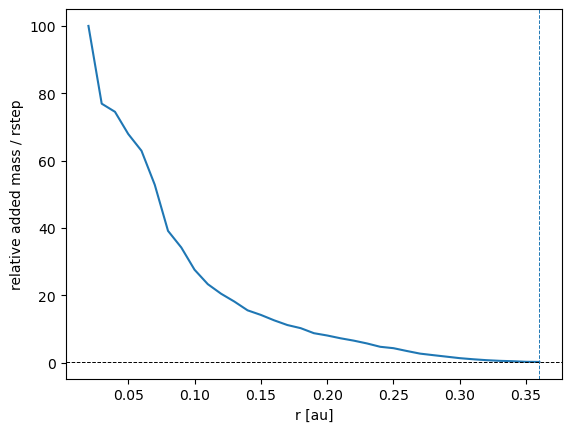

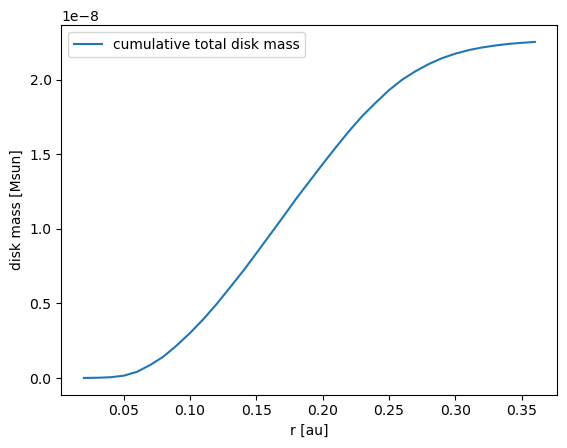

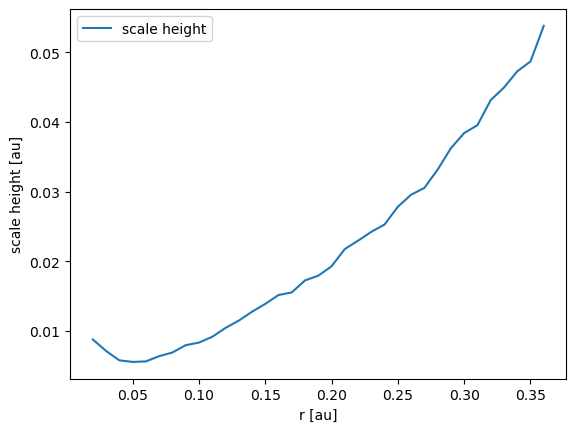

In [12]:
'''
Example
'''
run    = '/lhome/jolienm/Documents/TierModels/R_Aql/cooling/binariesInPaper/finalAccrDisks/v20e00_T3000_res8_racc01/'
dump = 292
main(run,dump,['1H'],full=True,quadrants=False)

In [ ]:
'''
Example
'''

#Non-eccentric runs --> use final full dump; do calculations for both scale height options and for both the full thetaregion and the four quadrants seperately to study asymmetries
run    = '/lhome/jolienm/Documents/TierModels/R_Aql/cooling/binariesInPaper/finalAccrDisks/v20e00_T3000_res8_racc01/'
dump = 292
main(run,dump,['1H','2H'],full=True,quadrants=True)

run    = '/lhome/jolienm/Documents/TierModels/R_Aql/cooling/binariesInPaper/finalAccrDisks/v10e00_T3000_res8_racc01/'
dump = 292
main(run,dump,['1H','2H'],full=True,quadrants=True)

run    = '/lhome/jolienm/Documents/TierModels/R_Aql/cooling/binariesInPaper/finalAccrDisks/v05e00_T3000_res8_racc01/'
dump = 292
main(run,dump,['1H','2H'],full=True,quadrants=True)


##eccentric runs --> Select interesting dumps throughout last orbit, compare calculations for full theta region

run    = '/lhome/jolienm/Documents/TierModels/R_Aql/cooling/binariesInPaper/finalAccrDisks/v05e50_T3000_res8_racc01/'
dump = 245
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 263
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 277
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 292
main(run,dump,['1H','2H'],full=True,quadrants=False)

run    = '/lhome/jolienm/Documents/TierModels/R_Aql/cooling/binariesInPaper/finalAccrDisks/v10e50_T3000_res8_racc01/'
dump = 245
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 263
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 277
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 292
main(run,dump,['1H','2H'],full=True,quadrants=False)

run    = '/lhome/jolienm/Documents/TierModels/R_Aql/cooling/binariesInPaper/finalAccrDisks/v20e50_T3000_res8_racc01/'
dump = 250
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 266
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 277
main(run,dump,['1H','2H'],full=True,quadrants=False)
dump = 292
main(run,dump,['1H','2H'],full=True,quadrants=False)


"Maybe add part for tests of different rsteps"